# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# import itertools

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# import torchvision.transforms as Transforms
# from torchvision.transforms import ToTensor

# Functions

In [4]:
def load_images(image_folder_path, num_images = None):
    """
    Arguments:
    image_folder_path - Path to folder containing images
    num_images - Number of images to retrieve
    Output:
    images - list of images converted into pytorch tensors
    """
    images = []
    if(num_images):
        for exp in os.listdir(image_folder_path):
            subfolder = os.path.join(image_folder_path, exp)
            filenames = os.listdir(subfolder)
            i = 0
            for filename in filenames:
                if(i == num_images):
                    break
                if(filename == ".ipynb_checkpoints"):
                    continue
                filepath = os.path.join(subfolder, filename)
                img = np.array(Image.open(filepath))
                img = np.resize(img, (1,48,48))
                images.append(img)
                i+=1
    else:
        for exp in os.listdir(image_folder_path):
            subfolder = os.path.join(image_folder_path, exp)
            filenames = os.listdir(subfolder)
            for filename in filenames:
                if(filename == ".ipynb_checkpoints"):
                    continue
                filepath = os.path.join(subfolder, filename)
                img = np.array(Image.open(filepath))
                img = np.resize(img, (1,48,48))
                images.append(img)
    return np.array(images)

In [5]:
images = load_images("FER/train", num_images=5)
print(images.shape)

(35, 1, 48, 48)


# Load and Explore data

In [6]:
os.getcwd()

'C:\\Users\\arvin\\MLProjectsFolder\\RTER'

In [7]:
img_size = 48
batch_size = 64

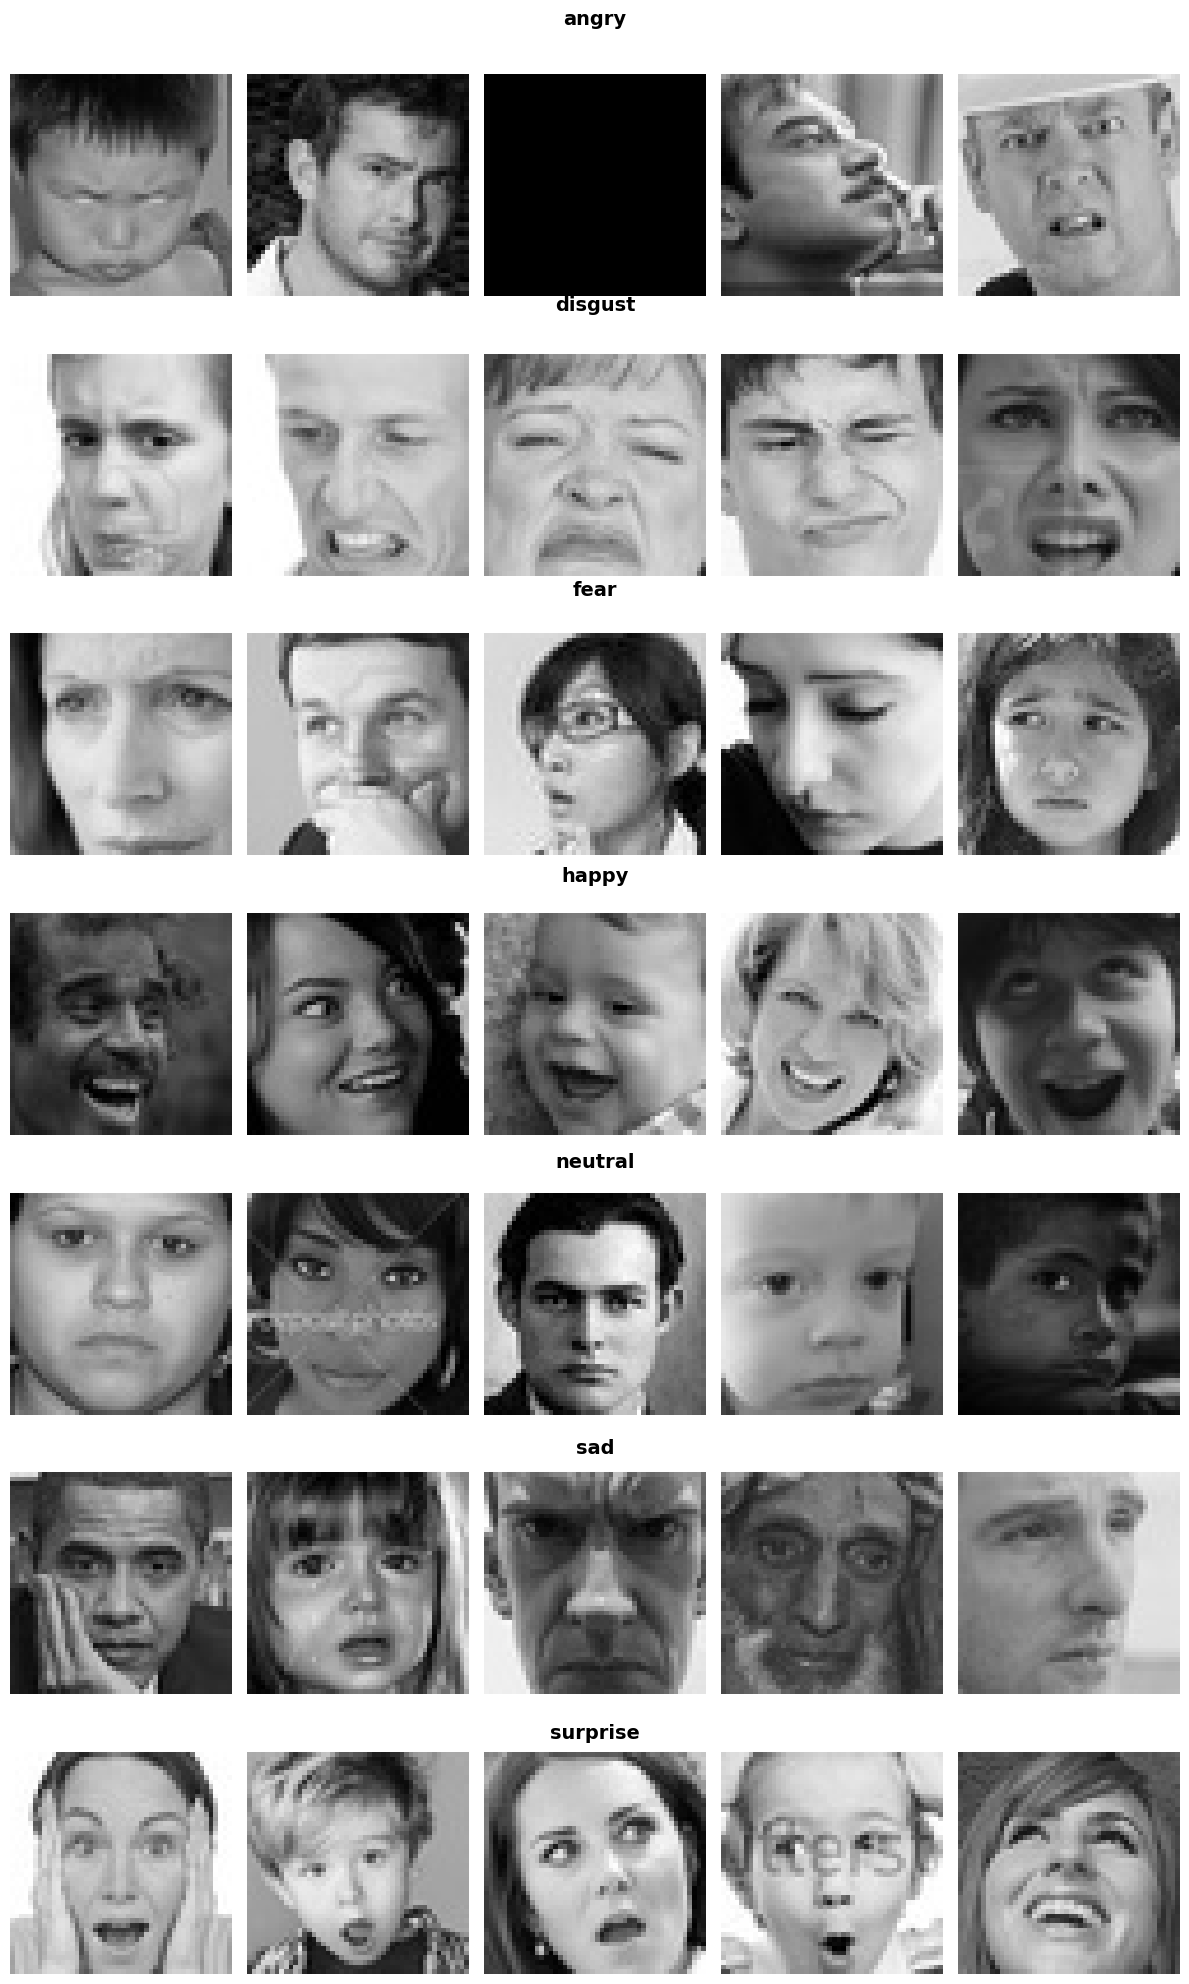

In [8]:
plt.figure(0, figsize = (12,20))
cnt = 0

for exp in os.listdir("FER/train"):
    subfolder = os.path.join("FER/train", exp)
    plt.figtext(0.5, 1-(cnt/35), exp, ha="center", fontsize=14, fontweight='bold')
    # print(f"\n{subfolder}\n")
    for i in range(1,6):
        filepath = os.path.join(subfolder, os.listdir(subfolder)[i])
        cnt += 1
        plt.subplot(7,5,cnt)
        img = cv2.imread(filepath)
        # print(f"Emotion: {exp}, filepath: {filepath}")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
plt.tight_layout()

# Custom Dataset

## Dataset:

In [9]:
class CustomDataset(Dataset):
    def __init__(self, images_folder_path):
        self.images = load_images(images_folder_path)
        self.images = torch.from_numpy(self.images).float()
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        return (self.images[idx]), (self.images[idx]/255.0)

In [10]:
train_ds = CustomDataset("FER/train")

## Dataloaders:

In [11]:
batch_size = 64

In [12]:
train_dataloader = DataLoader(train_ds, batch_size = batch_size, shuffle=True)

### Sanity check:

In [15]:
for _, batch in enumerate(train_dataloader):
    print(len(batch))
    # print(batch.shape)
    print(batch[0].shape, batch[1].shape)
    print(type(batch[1]))
    print(batch[0][0].shape, batch[1][0].shape)
    print(batch[0])
    print(batch[1])
    break

2
torch.Size([64, 1, 48, 48]) torch.Size([64, 1, 48, 48])
<class 'torch.Tensor'>
torch.Size([1, 48, 48]) torch.Size([1, 48, 48])
tensor([[[[189., 163., 127.,  ...,  48.,  68.,  81.],
          [160., 133., 125.,  ...,  30.,  32.,  51.],
          [145., 146., 135.,  ...,  58.,  51.,  77.],
          ...,
          [ 36.,  30.,  33.,  ..., 171., 179., 178.],
          [ 34.,  38.,  36.,  ..., 170., 170., 173.],
          [ 43.,  44.,  29.,  ..., 173., 176., 175.]]],


        [[[244., 230., 190.,  ..., 202., 202., 192.],
          [242., 223., 179.,  ..., 206., 198., 199.],
          [240., 208., 181.,  ..., 208., 207., 200.],
          ...,
          [149., 203., 221.,  ..., 147., 150., 147.],
          [135., 194., 223.,  ..., 150., 148., 152.],
          [124., 184., 221.,  ..., 154., 150., 155.]]],


        [[[  0.,   0.,   0.,  ..., 100.,  95.,  83.],
          [  0.,   3.,   0.,  ..., 107.,  99.,  84.],
          [  0.,   3.,   1.,  ..., 109., 106.,  96.],
          ...,
        

# Model

## Model Architecture

In [16]:
class AEModel(nn.Module):
    def encBlock(self, kernel_size):
        block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size = kernel_size),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size = kernel_size),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size = kernel_size),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        return block
    def bottleneck(self):
        block = nn.Sequential(
            nn.Linear(64*42*42, 1024),
            # nn.Linear(1024, 512),
            # nn.Linear(512, 256),
            # nn.Linear(256, 128),
            # nn.Linear(128, 256),
            # nn.Linear(256, 512),
            # nn.Linear(512, 1024),
            nn.Linear(1024, 64*42*42)
        )
        return block
    def decBlock(self, kernel_size):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=kernel_size),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=kernel_size),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=kernel_size),
            nn.Sigmoid()
        )
        return block
    def __init__(self, kernel_size):
        super(AEModel, self).__init__()
        self.encoder = self.encBlock(kernel_size = kernel_size)
        self.bot = self.bottleneck()
        self.decoder = self.decBlock(kernel_size = kernel_size)

    def forward(self, x, view_shapes = False):
        # print(view_shapes)
        if(view_shapes == True):
            print(x.shape)
            x = self.encoder(x)
            print(x.shape)
            x = x.view(x.size(0), -1)
            print(x.shape)
            x = self.bot(x)
            print(x.shape)
            x = x.view(x.size(0), 64,42,42)
            print(x.shape)
            x = self.decoder(x)
            print(x.shape)
            return x
        else:
            x = self.encoder(x)
            x = x.view(x.size(0), -1)
            x = self.bot(x)
            x = x.view(x.size(0), 64,42,42)
            x = self.decoder(x)
            return x

Conv2D:

((W−K+2P)/S)+1

ConvTranspose2D:

H = (H  − 1)×stride−2×padding+dilation×(kernel_size−1)+output_padding+1

 out \\ in

In [17]:
((48-3+2)//2)+1

24

In [18]:
((24-3+2)//2)+1

12

In [19]:
((12-3+2)//2)+1

6

In [21]:
class AEModel(nn.Module):
    def encBlock(self, kernel_size):
        block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size = kernel_size, stride = (2,2), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size = kernel_size, stride = (2,2), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size = kernel_size, stride = (2,2), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        return block

    def bottleneck(self):
        block = nn.Sequential(
            nn.Linear(64*6*6, 1024),
            # nn.Linear(1024, 512),
            # nn.Linear(512, 256),
            # nn.Linear(256, 128),
                # nn.Linear(128, 256),
                # nn.Linear(256, 512),
            # nn.Linear(512, 1024),
            nn.Linear(1024, 64*6*6)
        )
        return block

    def decBlock(self, kernel_size):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=kernel_size, stride = (2,2), padding = 1, output_padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=kernel_size, stride = (2,2), padding = 1, output_padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=kernel_size, stride = (2,2), padding = 1, output_padding=1, bias=False),
            nn.Tanh()
        )
        return block
    def __init__(self, kernel_size):
        super(AEModel, self).__init__()
        self.encoder = self.encBlock(kernel_size = kernel_size)
        self.bot = self.bottleneck()
        self.decoder = self.decBlock(kernel_size = kernel_size)

    def forward(self, x, view_shapes = False):
        # print(view_shapes)
        if(view_shapes == True):
            print(x.shape)
            x = self.encoder(x)
            print(x.shape)
            x = x.view(x.size(0), -1)
            print(x.shape)
            x = self.bot(x)
            print(x.shape)
            x = x.view(x.size(0), 64,6,6)
            print(x.shape)
            x = self.decoder(x)
            print(x.shape)
            return x
        else:
            x = self.encoder(x)
            x = x.view(x.size(0), -1)
            x = self.bot(x)
            x = x.view(x.size(0), 64,6,6)
            x = self.decoder(x)
            return x*255

In [22]:
model = AEModel(kernel_size=3)
# print(model)

# Training

In [23]:
if(torch.cuda.is_available):
    print("Using cuda")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using cuda


In [25]:
num_epochs = 200
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr = 0.01)

train_losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for _, (images, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images, view_shapes = False)
        
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_dataloader)}")
    train_losses.append(running_loss/len(train_dataloader))
for epoch in range(len(train_losses)):
    print(f"Epoch {epoch+1}, Loss: {train_losses[epoch]}")

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [24:30<00:00,  7.35s/it]

Epoch 1, Loss: 102.43456407140252
Epoch 2, Loss: 0.47620626865888227
Epoch 3, Loss: 0.5125305228482907
Epoch 4, Loss: 0.5537601113319397
Epoch 5, Loss: 0.4844204154371684
Epoch 6, Loss: 0.4040114250208328
Epoch 7, Loss: 0.3670629781809841
Epoch 8, Loss: 0.30103655570997695
Epoch 9, Loss: 0.2782442586326387
Epoch 10, Loss: 0.24520156794706804
Epoch 11, Loss: 0.21639104399888182
Epoch 12, Loss: 0.21126766965822016
Epoch 13, Loss: 0.1827924930571448
Epoch 14, Loss: 0.16373997659553133
Epoch 15, Loss: 0.15225710349783866
Epoch 16, Loss: 0.13015930024380143
Epoch 17, Loss: 0.1273389208174097
Epoch 18, Loss: 0.10696086726402387
Epoch 19, Loss: 0.10386850026110499
Epoch 20, Loss: 0.0917723465437082
Epoch 21, Loss: 0.08317086960133041
Epoch 22, Loss: 0.07622660373758633
Epoch 23, Loss: 0.06829238769272654
Epoch 24, Loss: 0.05836314035119086
Epoch 25, Loss: 0.049287506368816035
Epoch 26, Loss: 0.04303020183702221
Epoch 27, Loss: 0.0360246588473928
Epoch 28, Loss: 0.030384059688428992
Epoch 29, 

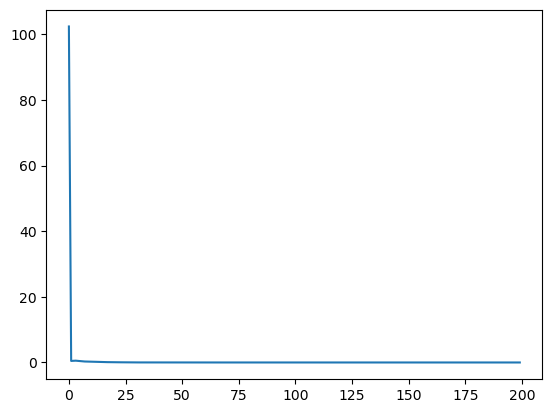

In [26]:
plt.plot(train_losses)

In [27]:
np_images = []
np_preds = []
model.eval()
with torch.inference_mode():
    for _, (images, targets) in enumerate(train_dataloader):
        images = images.to(device)
        targets = targets.to(device)
        preds = model(images)
        loss = criterion(targets, preds)
        print(loss)
        for image in images:
            np_image = (image.reshape((48,48, 1)).cpu()).numpy()/255
            np_images.append(np_image)
            
        for pred in preds:
            np_pred = pred.permute((1,2,0)).cpu().numpy()
            np_preds.append(np_pred)
            
        print(np_images[0].shape)
        print(np_preds[0].shape)
        break

tensor(0.0042, device='cuda:0')
(48, 48, 1)
(48, 48, 1)


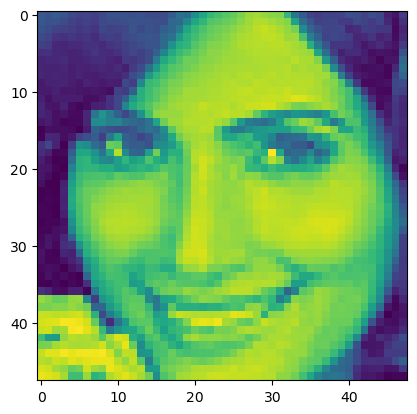

In [28]:
# print(np_images[0])
plt.imshow(np_images[0])

[[[0.26833242]
  [0.2798471 ]
  [0.28798878]
  ...
  [0.139911  ]
  [0.09126281]
  [0.07211898]]

 [[0.2720004 ]
  [0.2796705 ]
  [0.2841914 ]
  ...
  [0.14275552]
  [0.08614083]
  [0.06695496]]

 [[0.2503204 ]
  [0.25290516]
  [0.23401037]
  ...
  [0.12978534]
  [0.05660248]
  [0.04472919]]

 ...

 [[0.9810085 ]
  [1.0030689 ]
  [1.0186461 ]
  ...
  [0.15411155]
  [0.23405911]
  [0.17749332]]

 [[1.070799  ]
  [1.0809836 ]
  [0.9973262 ]
  ...
  [0.06533109]
  [0.07688435]
  [0.06075662]]

 [[0.86245584]
  [0.87676   ]
  [0.8032782 ]
  ...
  [0.05402294]
  [0.06192499]
  [0.04578659]]]


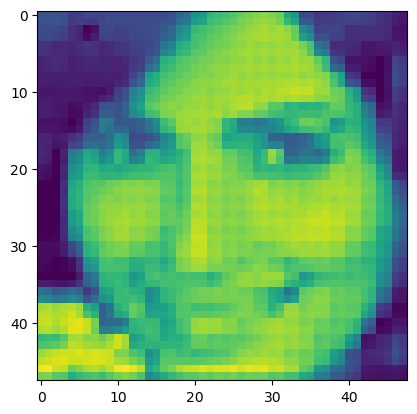

In [29]:
# print(np_preds[0])
print(np_preds[0])
plt.imshow(np_preds[0])